# Pre-process `developing human immune across tissue` for `bioLORD` (B-cells)


The data was generated by Suo et al.[[1]](https://www.science.org/doi/full/10.1126/science.abo0510) and downloaded from [Lymphoid cells](https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.LYMPHOID.embedding.h5ad). <br>
The complete dataset contains a cross-tissue single-cell atlas of developing human immune cells across prenatal hematopoietic, lymphoid, and nonlymphoid peripheral organs. This includes over 900,000 cells from which we identified over 100 cell states.

[[1] Suo, Chenqu, Emma Dann, Issac Goh, Laura Jardine, Vitalii Kleshchevnikov, Jong-Eun Park, Rachel A. Botting et al. "Mapping the developing human immune system across organs." Science (2022): eabo0510.](https://www.science.org/doi/full/10.1126/science.abo0510)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("/cs/labs/mornitzan/zoe.piran/research/projects/bioLORD")

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import biolord

import seaborn as sns
import matplotlib.pyplot as plt
import panfetal_utils
from bbknn import bbknn

ModuleNotFoundError: No module named 'biolord'

## Set parameters

In [4]:
sns.set_style("whitegrid", {'xtick.direction': 'out', 'xtick.major.size': 6.0, 'xtick.minor.size': 3.0,
    'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6.0, 'ytick.minor.size': 3.0, 
                           'font': ['DejaVu Sans'], 'font.scale': 1.6})

In [5]:
celltype_groups = {"MYELOID": ["DC2", "DC1", "NEUTROPHIL", "PROMONOCYTE", "OSTEOCLAST", "PRE_DC2", "MAST_CELL", "MOP", "EOSINOPHIL_BASOPHIL", "DC_PROGENITOR", "PDC", "MYELOCYTE", "MONOCYTE_I_CXCR4", "CYCLING_PDC", "MIGRATORY_DC", "DEVELOPING_NEPHRON_I", "DEVELOPING_NEPHRON_II", "AS_DC", "YS_STROMA", "YS_ERY", "CYCLING_YS_ERY", "CYCLING_DC", "MONOCYTE_II_CCR2", "MONOCYTE_III_IL1B", "MACROPHAGE_PROLIFERATING", "MACROPHAGE_MHCII_HIGH", "MACROPHAGE_LYVE1_HIGH", "MACROPHAGE_PERI", "LMPP_MLP", "FIBROBLAST_XVII", "LANGERHANS_CELLS", "MACROPHAGE_ERY", "MACROPHAGE_IRON_RECYCLING", "MACROPHAGE_KUPFFER_LIKE", "MACROPHAGE_TREM2"], "B CELLS": ["LARGE_PRE_B", "PRE_PRO_B", "PRO_B", "CYCLING_B", "SMALL_PRE_B", "MATURE_B", "B1", "IMMATURE_B", "LATE_PRO_B", "PLASMA_B"], "ERYTHROID CELLS": ["EARLY_ERY", "EARLY_MK", "PROMYELOCYTE", "MID_ERY", "LATE_ERY", "LATE_MK"], "ILC": ["ILC3", "ILC2", "CYCLING_ILC"], "OTHER": ["DOUBLET_IMMUNE_FIBROBLAST", "LOW_Q_INCONSISTENT", "DOUBLET_LYMPHOID_MACROPHAGE", "LOW_QUALITY", "HIGH_MITO", "DOUBLETS_FIBRO_ERY", "DOUBLET_ENDOTHELIUM_ERYTHROCYTE", "DOUBLET_ERY_B", "LOW_QUALITY_MACROPHAGE", "LOW_QUALITY_MID_ERY_(HIGH_RIBO)", "PLACENTAL_CONTAMINANTS", "DOUBLET"], "NK/T CELLS": ["CYCLING_T", "CD4+T", "CD8+T", "TREG", "NK", "CYCLING_NK", "DP(P)_T", "CD8AA", "ABT(ENTRY)", "DP(Q)_T", "DN(P)_T", "DN(early)_T", "DN(Q)_T", "TYPE_1_INNATE_T", "TYPE_3_INNATE_T"], "STROMA": ["MELANOCYTE", "MYOFIBROBLAST", "KERATINOCYTE", "GLIAL", "MESOTHELIUM", "SMOOTH_MUSCLE", "NEURON", "HEPATOCYTE-LIKE", "CYCLING_EPITHELIUM", "INTERSTITIAL_CELLS_OF_CAJAL", "MESENCHYMAL_LYMPHOID_TISSUE_ORGANISER", "MUSCLE_SATELLITE", "OSTEOBLAST", "SKELETAL_MUSCLE", "CHONDROCYTE", "ENDOTHELIUM_I", "VSMC_PERICYTE", "ENDOTHELIUM_II", "CYCLING_FIBROBLAST_I", "FIBROBLAST_IV", "CYCLING_FIBROBLAST_II", "ENDOTHELIUM_III", "ENDOTHELIUM_IV", "FIBROBLAST_I", "HEPATOCYTE_I", "HEPATOCYTE_II", "ENTEROENDOCRINE_I", "FIBROBLAST_II", "ENTEROENDOCRINE_II", "ENDOTHELIUM_V", "FIBROBLAST_III", "FIBROBLAST_V", "FIBROBLAST_VI", "FIBROBLAST_VII", "FIBROBLAST_VIII", "VSMC_PERICYTE_I", "FIBROBLAST_IX", "FIBROBLAST_X", "FIBROBLAST_XI", "EPITHELIUM_I", "EPITHELIUM_II", "MYOFIBROBLAST_I", "FIBROBLAST_XII", "VSMC_PERICYTE_II", "FIBROBLAST_XIII", "FIBROBLAST_XIV", "FIBROBLAST_XV", "FIBROBLAST_XVI", "VSMC_PERICYTE_III", "DOUBLET_VSMC_ERYTHROCYTE"], "PROGENITORS": ["MEMP", "GMP", "HSC_MPP", "MEP", "CMP", "CYCLING_MEMP", "CYCLING_MPP"]}

In [6]:
# DATA_DIR = "/cs/labs/mornitzan/zoe.piran/research/projects/bioLORD_data/data/tissue-age-celltype"
# SAVE_DIR = "/cs/labs/mornitzan/zoe.piran/research/projects/bioLORD_data/output/tissue-age-celltype"
DATA_DIR = "Data/human_immune‬/"
SAVE_DIR = "Output/" # set path to output  

## Import data and preprocess

Restrict data to `B cells` and follow the integration procedure, with respect to `donor` and `method`, as performed in the original study. <br> (following [integration_scRNA_BBKNN.ipynb](https://github.com/Teichlab/Pan_fetal_immune/blob/master/src/02_integration_scRNA/integration_scRNA_BBKNN.ipynb))

Data downloaded from [Lymphoid cells](https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.LYMPHOID.embedding.h5ad)

In [7]:
adata = sc.read(DATA_DIR + "/PAN.A01.v01.raw_count.20210429.LYMPHOID.embedding.h5ad")

Only considering the two last: ['.embedding', '.h5ad'].
Only considering the two last: ['.embedding', '.h5ad'].


In [8]:
adata_Bcells = adata[adata.obs["celltype_annotation"].isin(celltype_groups["B CELLS"])].copy()

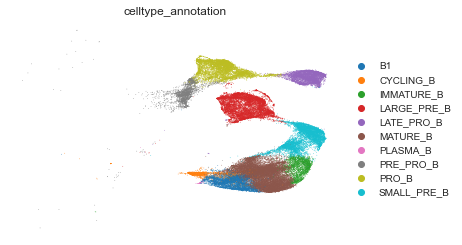

In [9]:
sc.pl.umap(adata_Bcells, color=["celltype_annotation"], frameon=False)

In [10]:
adata_Bcells.obs['batch'] = [x+y for x,y in zip(adata_Bcells.obs['organ'],adata_Bcells.obs['method'])]
adata_Bcells.obs['bbk'] = [x+y for x,y in zip(adata_Bcells.obs['donor'],adata_Bcells.obs['method'])]

### Regression of technical variables

Using ridge regression to regress out technical covariates (especially method) while conserving info on labels from expert annotation.


In [11]:
sc.pp.normalize_per_cell(adata_Bcells, counts_per_cell_after=10e4)
sc.pp.log1p(adata_Bcells)

In [12]:
adata_Bcells.layers["log_norm"] = adata_Bcells.X.copy()

In [13]:
adata_Bcells_pp = panfetal_utils.pfi_preprocess(adata_Bcells, how="")


Preprocessing runtime:  31.89479970932007


In [14]:
panfetal_utils.ridge_regression(adata_Bcells_pp, batch_key=['method','donor'],confounder_key=['old_annotation_uniform'])

adata_Bcells_pp.X = adata_Bcells_pp.layers['X_remain']
del adata_Bcells_pp.layers['X_remain']
del adata_Bcells_pp.layers['X_explained']

### Remove doublets


In [15]:
adata_Bcells_pp = adata_Bcells_pp[adata_Bcells_pp.obs["doublet_scores"] < 0.4]

### Integration with BBKNN


In [16]:
bbk_obs = adata_Bcells_pp.obs["bbk"].value_counts().index[adata_Bcells_pp.obs["bbk"].value_counts() > 5].values

In [17]:
adata_Bcells_pp = adata_Bcells_pp[adata_Bcells_pp.obs["bbk"].isin(bbk_obs)].copy()

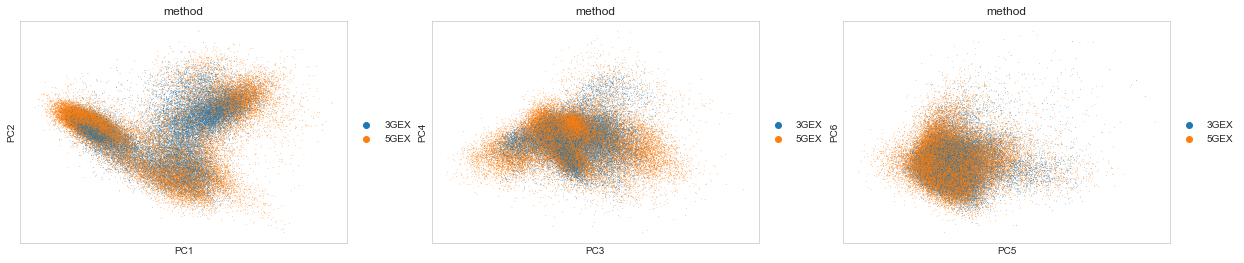

BBKNN runtime:  56.97525501251221
UMAP runtime:  145.49470376968384


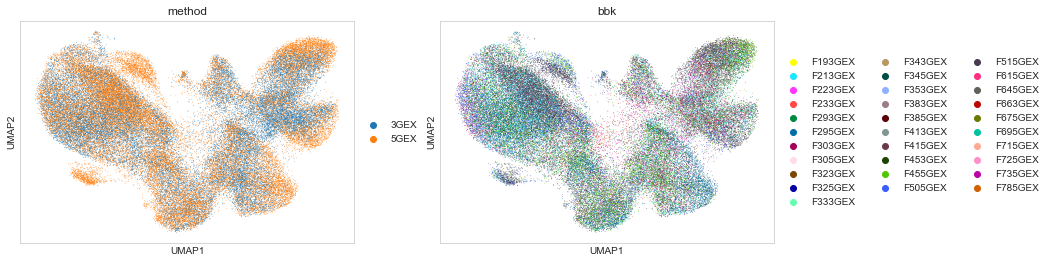

In [18]:
panfetal_utils.pfi_clustering(adata_Bcells_pp, how="pbu", use_highly_variable=False)

### Highly variable genes

In [19]:
sc.pp.highly_variable_genes(adata_Bcells_pp, min_mean=0.001, max_mean=10, subset=False)

### Clean `obs`

In [20]:
adata_Bcells_pp.obs["sex"] = adata_Bcells_pp.obs["sex"].astype(str).fillna("None")
adata_Bcells_pp.obs["sex"] = adata_Bcells_pp.obs["sex"].astype("category")
adata_Bcells_pp.obs["sex"]

index
FCAImmP7579224-CTAATGGCACTGTGTA    female
FCAImmP7579224-TCTTTCCCAAGCCGTC    female
FCAImmP7579224-GTATCTTAGCGACGTA    female
FCAImmP7579224-CCCAATCAGCCACGCT    female
FCAImmP7579224-GGAATAATCAGGTAAA    female
                                    ...  
FCAImmP7277565-TAGTTGGTCTCTGTCG      male
FCAImmP7277565-CAGGTGCAGACGCAAC      male
FCAImmP7277565-GTGCAGCAGAGCTGGT      male
FCAImmP7277565-TACTCGCCACGTCTCT      male
FCAImmP7277565-GAACATCGTACCAGTT      male
Name: sex, Length: 63996, dtype: category
Categories (3, object): ['female', 'male', 'nan']

In [21]:
adata_Bcells_pp.obs["celltype"] = adata_Bcells_pp.obs["celltype_annotation"].astype(str).copy()
adata_Bcells_pp.obs["celltype"] = adata_Bcells_pp.obs["celltype"].astype("category")
adata_Bcells_pp.obs["celltype"]

index
FCAImmP7579224-CTAATGGCACTGTGTA    LARGE_PRE_B
FCAImmP7579224-TCTTTCCCAAGCCGTC      PRE_PRO_B
FCAImmP7579224-GTATCTTAGCGACGTA          PRO_B
FCAImmP7579224-CCCAATCAGCCACGCT          PRO_B
FCAImmP7579224-GGAATAATCAGGTAAA      PRE_PRO_B
                                      ...     
FCAImmP7277565-TAGTTGGTCTCTGTCG    SMALL_PRE_B
FCAImmP7277565-CAGGTGCAGACGCAAC    SMALL_PRE_B
FCAImmP7277565-GTGCAGCAGAGCTGGT     LATE_PRO_B
FCAImmP7277565-TACTCGCCACGTCTCT    SMALL_PRE_B
FCAImmP7277565-GAACATCGTACCAGTT    SMALL_PRE_B
Name: celltype, Length: 63996, dtype: category
Categories (10, object): ['B1', 'CYCLING_B', 'IMMATURE_B', 'LARGE_PRE_B', ..., 'PLASMA_B', 'PRE_PRO_B', 'PRO_B', 'SMALL_PRE_B']

In [22]:
adata_Bcells_pp.obs["organ_age"] = adata_Bcells_pp.obs["organ"].astype(str) + "_" + adata_Bcells_pp.obs["age"].astype(str)
adata_Bcells_pp.obs["organ_age"] = adata_Bcells_pp.obs["organ_age"].astype("category")
adata_Bcells_pp.obs["organ_age"].value_counts()

SP_14     8678
BM_14     8600
BM_17     6596
BM_16     5637
SP_17     5636
LI_12     3740
SP_12     3473
BM_12     3374
SP_16     2364
LI_16     2216
SP_15     2012
BM_15     1557
SK_14     1311
LI_17     1179
LI_14     1100
LI_7      1084
LI_9       944
SK_12      609
LI_11      495
MLN_17     413
KI_16      385
GU_15      355
LI_8       294
TH_12      270
TH_17      264
SP_11      252
SK_15      242
MLN_16     238
TH_14      125
TH_16      120
KI_12       96
GU_16       77
YS_7        53
SK_9        49
SK_7        45
TH_11       39
KI_7        16
SK_11       15
SK_16       12
SK_10       10
TH_7         9
SK_8         3
SP_9         3
LI_10        3
GU_17        3
Name: organ_age, dtype: int64

### Set `split`

In [23]:
ood_set = [
 'TH_14',
 'GU_12',
 'KI_16']
adata_Bcells_pp.obs['split'] = 'nan'
adata_Bcells_pp.obs.loc[
    adata_Bcells_pp.obs['organ_age'].isin(ood_set), "split"
] = 'ood'
adata_idx = adata_Bcells_pp.obs_names[adata_Bcells_pp.obs["split"] != 'ood']
adata_idx_train, adata_idx_test = train_test_split(adata_idx, test_size=0.2, random_state=42)
adata_Bcells_pp.obs.loc[adata_idx_train, "split"] = 'train'
adata_Bcells_pp.obs.loc[adata_idx_test, "split"] = 'test'
adata_Bcells_pp.obs['split'].value_counts()

train    50788
test     12698
ood        510
Name: split, dtype: int64

In [24]:
adata_Bcells_pp

AnnData object with n_obs × n_vars = 63996 × 4204
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'batch', 'bbk', 'celltype', 'organ_age', 'split'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var', 'mean', 'std'
    uns: 'dendrogram_scvi_clusters', 'scvi', 'celltype_annotation_colors', 'log1p', 'hvg', 'pca', 'method_colors', 'neighbors', 'umap', 'bbk_colors'
    obsm: 'X_scvi', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'log_norm'
    obsp: 'scvi_connectivities', 'scvi_distances', 'distances', 'connectivities'

## Save output

In [25]:
adata_Bcells_pp.write(DATA_DIR + "/immune_bcells_biolord.h5ad")